In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.jobstatus import JobStatus
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [12]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

In [2]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="e3d76332de187f9b82dbd1904444ae8aaca1b80ed6fa6b8ae43d3b8f2641c0eea75884a158e0208d8d46c6d03551260f840427bfee34f4e323e13454fbf86fdf",
    overwrite=True,
    set_as_default=True,
)
service = QiskitRuntimeService(channel="ibm_quantum")

/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_24158/3590335105.py:7: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


In [6]:
jobID = "d09n5qerxz8g008a31m0"  # Replace with your job ID
retrieved_job = service.job(job_id=jobID)
status = retrieved_job.status()
print(f"Job Status: {status}")
if status == 'DONE':
        print("Job finished successfully. Getting results...")
        # Set a timeout (in seconds) for retrieving results, optional
        result = retrieved_job.result(timeout=300)
        print("Results retrieved successfully.")

Job Status: DONE
Job finished successfully. Getting results...
Results retrieved successfully.


{21: 0.0397, 2: 0.0198, 17: 0.0239, 25: 0.0301, 19: 0.0315, 12: 0.0303, 15: 0.0223, 30: 0.0288, 0: 0.0147, 9: 0.0458, 10: 0.0352, 13: 0.0365, 24: 0.0286, 27: 0.0325, 8: 0.028, 22: 0.0504, 1: 0.0216, 20: 0.0464, 11: 0.0483, 6: 0.0217, 26: 0.045, 18: 0.0418, 14: 0.0241, 3: 0.0288, 7: 0.027, 4: 0.0286, 29: 0.0254, 5: 0.0433, 28: 0.0309, 16: 0.0231, 23: 0.027, 31: 0.0189}
Result bitstring: [0, 1, 1, 0, 1]


/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_24158/3296566793.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


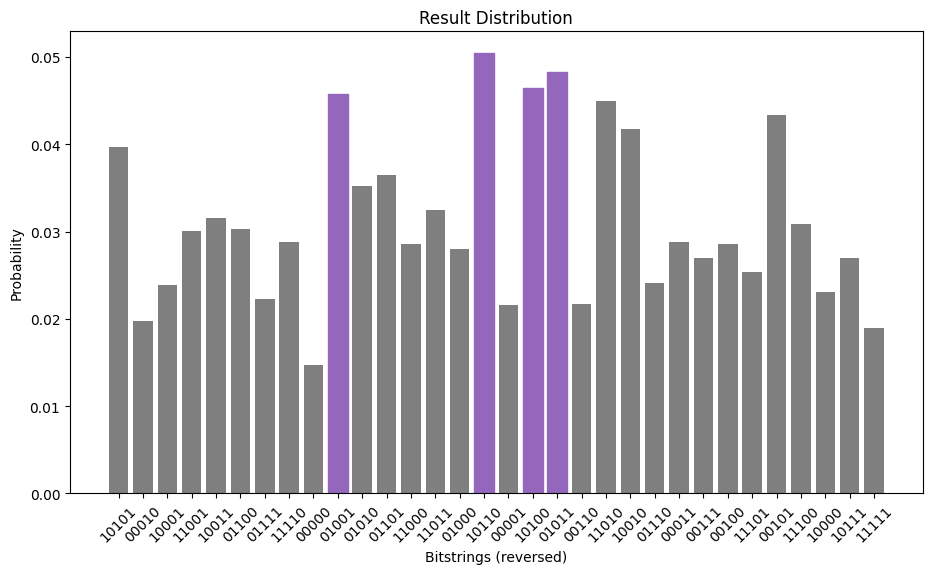

In [ ]:
#Following taken from https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm
#For the specific maxcut problemin the example, will probably need diferent result processing when the variables represent things other than nodes
counts_int = result[0].data.meas.get_int_counts()
counts_bin = result[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, 5) #5 is used as there are 5 nodes in the graph for the exmaple max cut problem
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()


